In [1]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lsgd import LSGD
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
from optimizers.lsgd import APLSGD
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import tqdm
import math
from training.train import train, plot_langevin_loss
from diffusion.deephedging import DeepHedging
from scheduler import PiecewiseConstantScheduler

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Single control:

In [2]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25
epochs = 100

In [3]:
alpha = 0.9
ell = lambda x: nn.functional.relu(x) / (1.0 - alpha)
dim = 5
s0 = 1.0
v0 = 0.1


model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=1 + 4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

In [4]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
adam_control = optim.Adam(ocp.control.parameters(), lr=2e-3)
adam = [optim_w, adam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [5]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, Adam, lr=0.000, sigma=[0], train=0.323, test=0.312: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


In [6]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ladam_control = LAdam(ocp.control.parameters(), lr=2e-3, sigma=2e-4)
ladam = [optim_w, ladam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    ladam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [7]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 96, LAdam, lr=0.000, sigma=[0], train=0.183, test=0.155:  97%|█████████▋| 97/100 [00:49<00:01,  1.86it/s]     

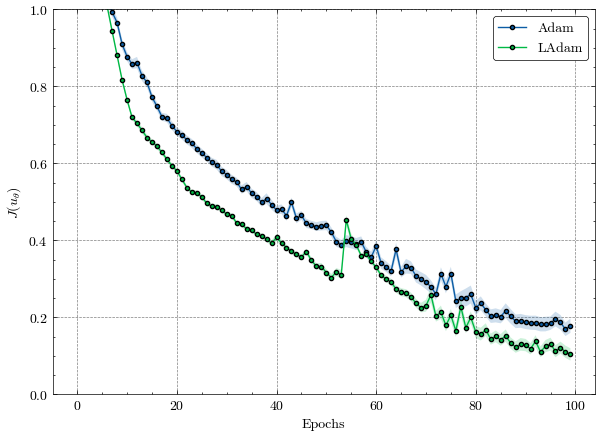

In [ ]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    name="Adam",
    ylim=(0, 1),
)

In [23]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
adadelta_control = optim.Adadelta(ocp.control.parameters(), lr=5e-1, rho=0.95)
adadelta = [optim_w, adadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adadelta_control, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [24]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, Adadelta, lr=0.050, sigma=[0], train=0.500, test=0.495: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


In [25]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ladadelta_control = LAdadelta(ocp.control.parameters(), lr=5e-1, sigma=5e-3)
ladadelta = [optim_w, ladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    ladadelta_control, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [26]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, LAdadelta, lr=0.050, sigma=[0], train=0.200, test=0.199: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]   


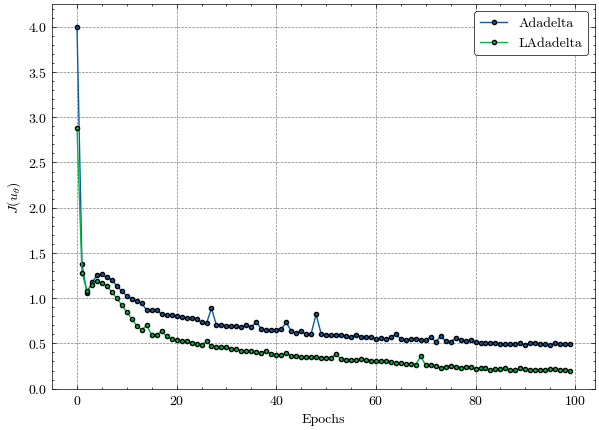

In [27]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    name="Adadelta",
)

In [28]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
rmsprop_control = optim.RMSprop(ocp.control.parameters(), lr=2e-3)
rmsprop = [optim_w, rmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    rmsprop_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [29]:
train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, RMSprop, lr=0.000, sigma=[0], train=0.311, test=0.311: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


In [30]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
lrmsprop_control = LRMSprop(ocp.control.parameters(), lr=2e-3, sigma=2e-4)
lrmsprop = [optim_w, lrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    lrmsprop_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [31]:
train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, LRMSprop, lr=0.000, sigma=[0], train=0.362, test=0.361: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]    


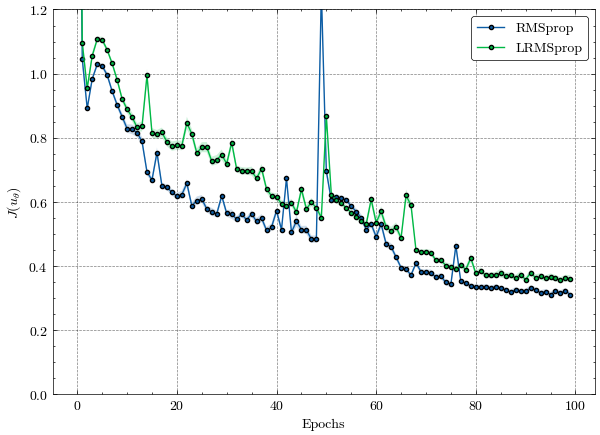

In [35]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    name="RMSprop",
    ylim=(0, 1.2),
)

### Multiple controls:

In [36]:
model_config = dict(
    T=1.0,
    N_euler=10,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

epochs = 200

In [37]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
adam_control = [optim.Adam(control.parameters(), lr=2e-3) for control in ocp.control]
adam = [optim_w, *adam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in adam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [38]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adam, lr=0.000, sigma=[0], train=0.650, test=0.661: 100%|██████████| 200/200 [00:22<00:00,  8.93it/s]


In [39]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ladam_control = [
    LAdam(control.parameters(), lr=2e-3, sigma=2e-4) for control in ocp.control
]
ladam = [optim_w, *ladam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in ladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [40]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LAdam, lr=0.000, sigma=[0], train=0.390, test=0.378: 100%|██████████| 200/200 [00:23<00:00,  8.52it/s]     


In [41]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 30
lladam_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam_control.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam_control.append(optim.Adam(control.parameters(), lr=2e-3))

lladam = [optim_w, *lladam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [42]:
train_loss_ll30_adam, test_loss_ll30_adam, test_ci_ll30_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdam, lr=0.000, sigma=[0], train=0.451, test=0.439: 100%|██████████| 200/200 [00:20<00:00,  9.56it/s]


In [43]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 90
lladam_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam_control.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam_control.append(optim.Adam(control.parameters(), lr=2e-3))

lladam = [optim_w, *lladam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [44]:
train_loss_ll90_adam, test_loss_ll90_adam, test_ci_ll90_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdam, lr=0.000, sigma=[0], train=0.311, test=0.278: 100%|██████████| 200/200 [00:21<00:00,  9.38it/s]     


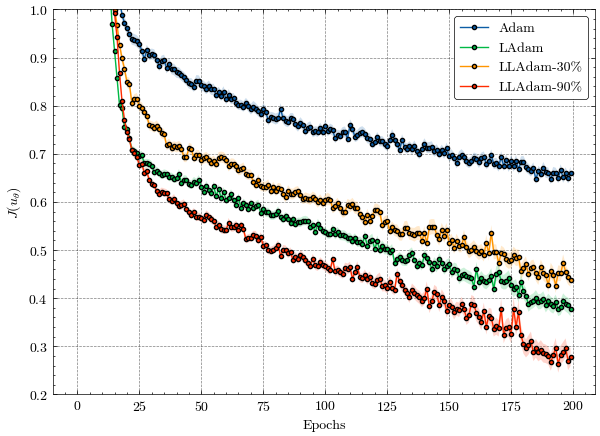

In [46]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    test_loss_llangevin=[test_loss_ll30_adam, test_loss_ll90_adam],
    test_ci_llangevin=[test_ci_ll30_adam, test_ci_ll90_adam],
    ll=[30, 90],
    name="Adam",
    ylim=(0.2, 1.0),
)

In [47]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
adadelta_control = [
    optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95) for control in ocp.control
]
adadelta = [optim_w, *adadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in adadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [48]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adadelta, lr=0.050, sigma=[0], train=0.790, test=0.789: 100%|██████████| 200/200 [00:23<00:00,  8.61it/s]


In [49]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ladadelta_control = [
    LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3) for control in ocp.control
]
ladadelta = [optim_w, *ladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in ladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [50]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LAdadelta, lr=0.050, sigma=[0], train=0.275, test=0.256: 100%|██████████| 200/200 [00:23<00:00,  8.47it/s]    


In [51]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 30
lladadelta_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta_control.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta_control.append(
            optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95)
        )

lladadelta = [optim_w, *lladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in lladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [52]:
train_loss_ll30_adadelta, test_loss_ll30_adadelta, test_ci_ll30_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdadelta, lr=0.050, sigma=[0], train=0.540, test=0.533: 100%|██████████| 200/200 [00:20<00:00,  9.54it/s]


In [53]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 90
lladadelta_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta_control.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta_control.append(
            optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95)
        )

lladadelta = [optim_w, *lladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in lladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [54]:
train_loss_ll90_adadelta, test_loss_ll90_adadelta, test_ci_ll90_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdadelta, lr=0.050, sigma=[0], train=0.241, test=0.206: 100%|██████████| 200/200 [00:21<00:00,  9.27it/s]    


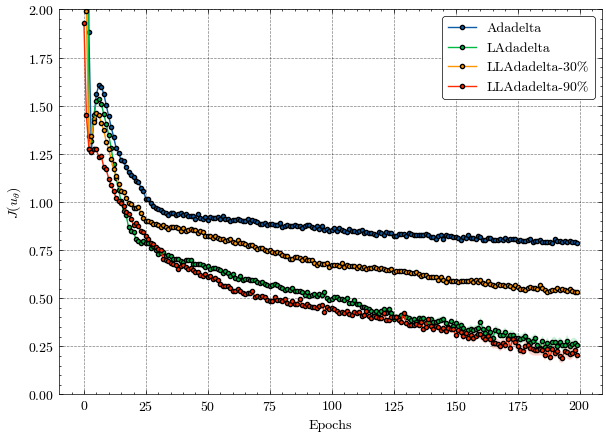

In [56]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    test_loss_llangevin=[test_loss_ll30_adadelta, test_loss_ll90_adadelta],
    test_ci_llangevin=[test_ci_ll30_adadelta, test_ci_ll90_adadelta],
    ll=[30, 90],
    name="Adadelta",
    ylim=(0, 2),
)

In [57]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
rmsprop_control = [
    optim.RMSprop(control.parameters(), lr=2e-3) for control in ocp.control
]
rmsprop = [optim_w, *rmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in rmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [58]:
train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, RMSprop, lr=0.000, sigma=[0], train=0.565, test=0.593: 100%|██████████| 200/200 [00:23<00:00,  8.64it/s]


In [59]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
lrmsprop_control = [
    LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3) for control in ocp.control
]
lrmsprop = [optim_w, *lrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [60]:
train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LRMSprop, lr=0.000, sigma=[0], train=0.504, test=0.503: 100%|██████████| 200/200 [00:22<00:00,  8.90it/s]    


In [61]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 30
llrmsprop_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop_control.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop_control.append(optim.RMSprop(control.parameters(), lr=2e-3))

llrmsprop = [optim_w, *llrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [62]:
train_loss_ll30_rmsprop, test_loss_ll30_rmsprop, test_ci_ll30_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLRMSprop, lr=0.000, sigma=[0], train=0.493, test=0.479: 100%|██████████| 200/200 [00:20<00:00,  9.61it/s]


In [63]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
ll = 90
llrmsprop_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop_control.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop_control.append(optim.RMSprop(control.parameters(), lr=2e-3))

llrmsprop = [optim_w, *llrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [64]:
train_loss_ll90_rmsprop, test_loss_ll90_rmsprop, test_ci_ll90_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLRMSprop, lr=0.000, sigma=[0], train=0.326, test=0.309: 100%|██████████| 200/200 [00:21<00:00,  9.41it/s]    


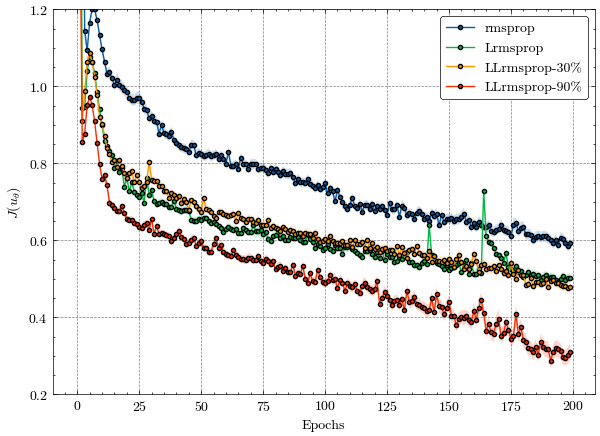

In [66]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    test_loss_llangevin=[test_loss_ll30_rmsprop, test_loss_ll90_rmsprop],
    test_ci_llangevin=[test_ci_ll30_rmsprop, test_ci_ll90_rmsprop],
    ll=[30, 90],
    name="rmsprop",
    ylim=(0.2, 1.2),
)

### Sample trajectory:

In [67]:
alpha = 0.9
ell = lambda x: nn.functional.relu(x) / (1.0 - alpha)
dim = 1
s0 = 1.0
v0 = 0.1


model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=1 + 4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

In [68]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
adam_control = optim.Adam(ocp.control.parameters(), lr=2e-3)
adam = [optim_w, adam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [69]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adam, lr=0.000, sigma=[0], train=0.081, test=0.081: 100%|██████████| 200/200 [00:49<00:00,  4.02it/s]


In [74]:
S1, S2, V, u = ocp.sample_traj(1)

Sampling trajectories: 100%|██████████| 50/50 [00:00<00:00, 5825.42it/s]


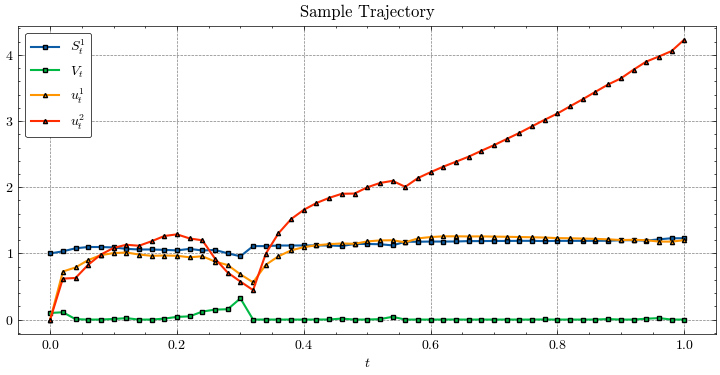

In [75]:
fig = plt.figure(figsize=(9, 4))

t = model_config["T"] / model_config["N_euler"] * np.arange(model_config["N_euler"] + 1)
plt.plot(
    t,
    S1.flatten().detach().numpy(),
    label=r"$S_t^1$",
    marker="s",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t, V.flatten().detach().numpy(), label=r"$V_t$", marker="s", mec="k", ms=3, lw=1.5
)
plt.plot(
    t,
    u[:, :, 0].flatten().detach().numpy(),
    label=r"$u_t^1$",
    marker="^",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t,
    u[:, :, 1].flatten().detach().numpy(),
    label=r"$u_t^2$",
    marker="^",
    mec="k",
    ms=3,
    lw=1.5,
)

legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.title("Sample Trajectory")
plt.xlabel(r"$t$")
# fig.savefig("graphs/deephedging/Sample_traj_N50.pdf")
plt.show()
plt.close()